In [1]:
#Proyecto de recomendación de bolsos para dama
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



# Montar drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

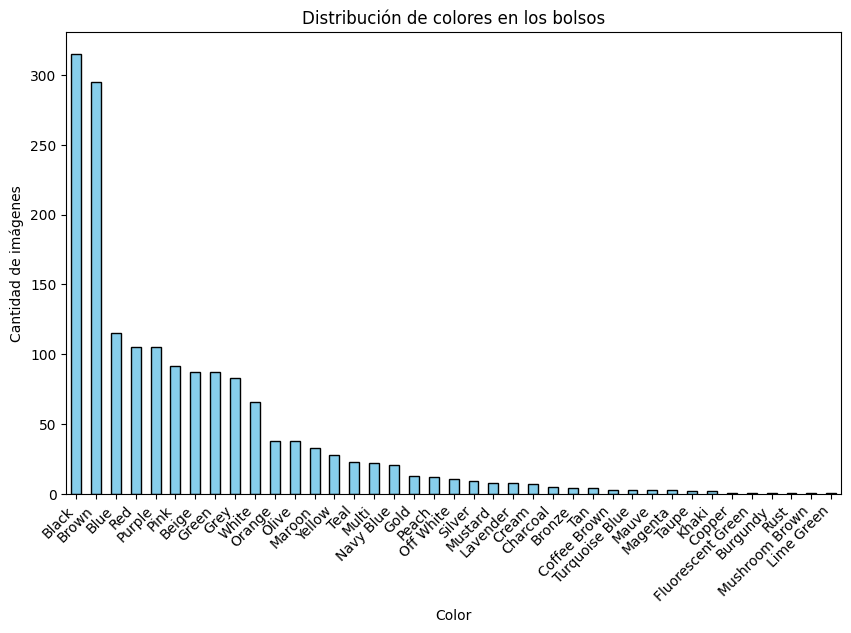

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Inteligencia Artificial I/Proyecto/filtered_bags_women.csv")
# Contar cuántos bolsos hay por color
color_counts = df["baseColour"].value_counts()

# --- Gráfico de barras ---
plt.figure(figsize=(10,6))
color_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribución de colores en los bolsos")
plt.xlabel("Color")
plt.ylabel("Cantidad de imágenes")
plt.xticks(rotation=45, ha="right")
plt.show()

# Métodos para la extracción de características

| Enfoque                                   | Qué hace                                                                    | Tamaño sugerido |
| ----------------------------------------- | ---------------------------------------------------------------------------- | --------------- |
| **Usar histogramas de color (HSV o RGB)** | Extraes la distribución de color dominante (por ejemplo, 32 bins por canal). | 64×64           |
| **Extraer color promedio o media RGB**    | Tomas el promedio de los valores R, G y B (3 características por imagen).    | 64×64           |
| **Usar texturas o bordes (HOG, LBP)**     | Capturas patrones de forma y textura.                                        | 100×100         |
| **Flatten (píxeles como features)**       | Convierte toda la imagen en un vector largo (rara vez recomendado).          | 32×32 o 64×64   |


# Funcion para mostrar imagen

Ruta usada: /content/drive/MyDrive/Inteligencia Artificial I/Proyecto/Imagenes_bolsos/Brown/1161.jpg


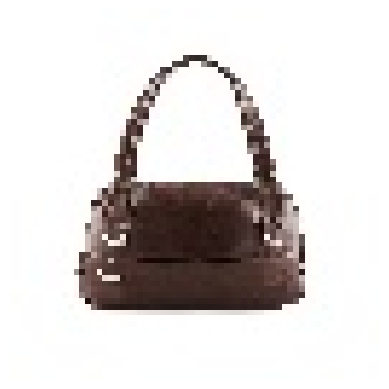

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import requests
from io import BytesIO
def ver_imagen(id, original=False):
    color = df["baseColour"][id]
    local_path = f"/content/drive/MyDrive/Inteligencia Artificial I/Proyecto/Imagenes_bolsos/{color}/{id}.jpg"
    img_path = df["image"][id] if original else local_path

    print("Ruta usada:", img_path)

    # Si la ruta es una URL externa
    if str(img_path).startswith("http"):
        response = requests.get(img_path)
        img = Image.open(BytesIO(response.content))
        plt.imshow(img)
    else:
        img = mpimg.imread(img_path)
        plt.imshow(img)

    plt.axis("off")
    plt.show()

ver_imagen(1161)

# Extracción de caracteristicas por histogramas de color

# Ejemplo para extraer histograma de color RGB

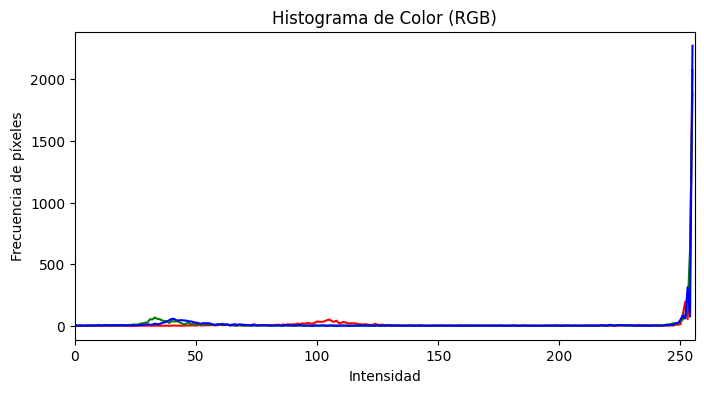

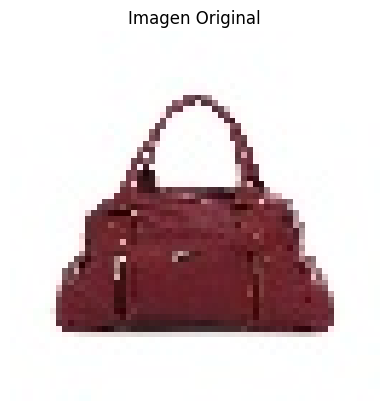

In [ ]:
import cv2
import matplotlib.pyplot as plt

# === 1. Ruta de tu imagen (ajústala al archivo que quieras probar) ===
img_path = "/content/drive/MyDrive/Inteligencia Artificial I/Proyecto/Imagenes_bolsos/Red/134.jpg"
# === 2. Cargar imagen ===
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === 3. Calcular histogramas para cada canal (R, G, B) ===
colors = ('r', 'g', 'b')
plt.figure(figsize=(8,4))

for i, color in enumerate(colors):
    hist = cv2.calcHist([img_rgb], [i], None, [256], [0, 256])
    plt.plot(hist, color=color)
    plt.xlim([0, 256])

plt.title("Histograma de Color (RGB)")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia de píxeles")
plt.show()

# === 4. Mostrar la imagen ===
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Imagen Original")
plt.show()


- cv2.calcHist() calcula el histograma de un canal de color (0=R, 1=G, 2=B).

- Cada histograma tiene 256 valores (niveles de intensidad de 0 a 255).

- Luego se grafican los tres histogramas en un mismo gráfico, cada uno con su color correspondiente.

# Extraer histograma de color HSV

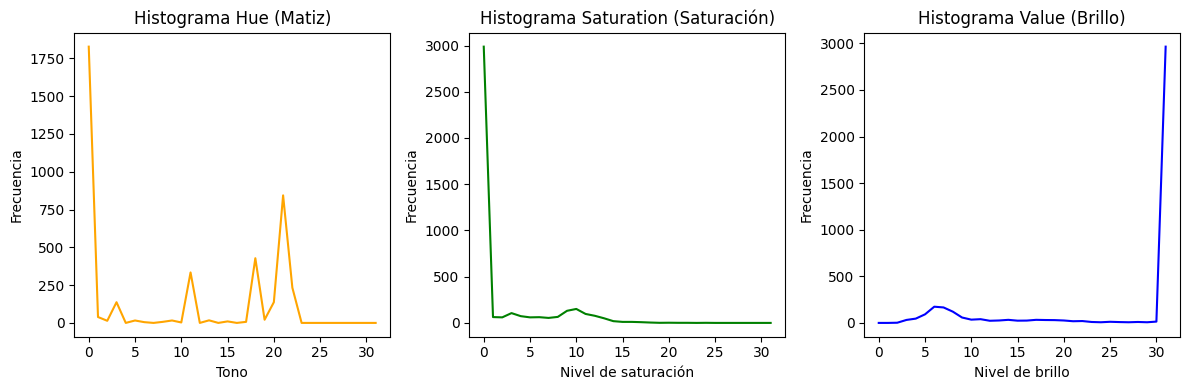

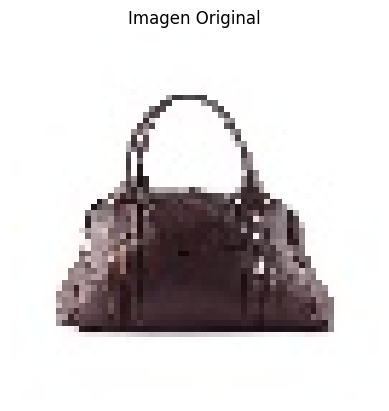

In [ ]:
import cv2
import matplotlib.pyplot as plt

# === 1. Ruta de tu imagen ===
img_path = "/content/drive/MyDrive/Inteligencia Artificial I/Proyecto/Imagenes_bolsos/Beige/5.jpg"

# === 2. Cargar imagen ===
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# === 3. Convertir a HSV ===
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# === 4. Calcular histogramas de H, S y V ===

h_hist = cv2.calcHist([img_hsv], [0], None, [180], [0, 180])  # Hue: 0-180
s_hist = cv2.calcHist([img_hsv], [1], None, [256], [0, 256])  # Saturation: 0-255
v_hist = cv2.calcHist([img_hsv], [2], None, [256], [0, 256])  # Value: 0-255

# === 5. Graficar los histogramas ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(h_hist, color='orange')
plt.title('Histograma Hue (Matiz)')
plt.xlabel('Tono')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.plot(s_hist, color='green')
plt.title('Histograma Saturation (Saturación)')
plt.xlabel('Nivel de saturación')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.plot(v_hist, color='blue')
plt.title('Histograma Value (Brillo)')
plt.xlabel('Nivel de brillo')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# === 6. Mostrar la imagen original ===
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Imagen Original")
plt.show()


# Extracción de caracteristicas de las imagenes

Acontinuación se van a extraer las características de las imagenes usando los dos métodos propuestos anteriormente es decir usando histogramas RGB o usando histogramas HSV

## Caracteristicas RGB

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

# Ruta al dataset
base_path = "/content/drive/MyDrive/Inteligencia Artificial I/Proyecto/Imagenes_bolsos"

# Crear listas para datos
features = []
labels = []
ids = []

# Número de bins por canal (ajústalo si quieres más o menos detalle)
bins = 32

# Recorremos las carpetas (cada carpeta = una clase/color)
for color_folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, color_folder)

    if not os.path.isdir(folder_path):
        continue

    for img_name in tqdm(os.listdir(folder_path), desc=f"Procesando {color_folder}"):
        img_path = os.path.join(folder_path, img_name)

        # Cargar imagen
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Extraer id (sin extensión)
        img_id = os.path.splitext(img_name)[0]

        # Convertir a RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Calcular histograma (3 canales)
        hist_r = cv2.calcHist([img], [0], None, [bins], [0, 256])
        hist_g = cv2.calcHist([img], [1], None, [bins], [0, 256])
        hist_b = cv2.calcHist([img], [2], None, [bins], [0, 256])

        # Normalizar y aplanar
        hist_r = cv2.normalize(hist_r, hist_r).flatten()
        hist_g = cv2.normalize(hist_g, hist_g).flatten()
        hist_b = cv2.normalize(hist_b, hist_b).flatten()

        # Concatenar en un solo vector
        feature_vector = np.concatenate([hist_r, hist_g, hist_b])

        # Guardar vector + etiqueta + id
        features.append(feature_vector)
        labels.append(color_folder)
        ids.append(img_id)

# Crear DataFrame con columnas nombradas
col_names = [f"r{i}" for i in range(bins)] + [f"g{i}" for i in range(bins)] + [f"b{i}" for i in range(bins)]
features_df = pd.DataFrame(features, columns=col_names)
features_df["id"] = ids
features_df["color"] = labels

# Guardar a CSV
output_csv = "/content/drive/MyDrive/Inteligencia Artificial I/Proyecto/histogram_features_RGB.csv"
features_df.to_csv(output_csv, index=False)

print(f"✅ Dataset guardado en: {output_csv}")
print(f"Dimensiones del dataset: {features_df.shape}")


Procesando White: 100%|██████████| 66/66 [00:30<00:00,  2.16it/s]


✅ Dataset guardado en: /content/drive/MyDrive/Inteligencia Artificial I/Proyecto/histogram_features.csv
Dimensiones del dataset: (1366, 98)


In [ ]:
features_df.head()
features_df[features_df["id"] == "1179"]

,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,b24,b25,b26,b27,b28,b29,b30,b31,id,label
822,0.0,0.0,0.0,0.000353,0.001411,0.000705,0.001058,0.002116,0.003174,0.003879,...,0.001808,0.000362,0.002169,0.001085,0.001085,0.007231,0.022053,0.987332,1179,Brown


## Características HSV

In [6]:
import cv2
import numpy as np
import os
import pandas as pd

# Ruta principal donde están las carpetas por color
base_path = '/content/drive/MyDrive/Inteligencia Artificial I/Proyecto/Imagenes_bolsos'

# Lista para almacenar los datos
data = []
ids = []
bins = 32

# Recorremos cada carpeta (una por color)
for color_folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, color_folder)
    if not os.path.isdir(folder_path):
        continue

    # Recorremos las imágenes dentro de cada carpeta
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        # Extraer id (sin extensión)
        img_id = os.path.splitext(img_name)[0]

        # Cargamos la imagen
        image = cv2.imread(img_path)
        if image is None:
            continue

        # Convertimos a HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Calculamos histograma por canal (H, S, V)
        hist_h = cv2.calcHist([hsv], [0], None, [bins], [0, 180])
        hist_s = cv2.calcHist([hsv], [1], None, [bins], [0, 256])
        hist_v = cv2.calcHist([hsv], [2], None, [bins], [0, 256])

        # Normalizamos cada histograma
        hist_h = cv2.normalize(hist_h, hist_h).flatten()
        hist_s = cv2.normalize(hist_s, hist_s).flatten()
        hist_v = cv2.normalize(hist_v, hist_v).flatten()

        # Concatenamos en un solo vector
        features = np.concatenate([hist_h, hist_s, hist_v])

        # Guardamos el nombre del archivo, la etiqueta (color) y el vector
        data.append([img_id, color_folder] + features.tolist())

        #agregar ids
        ids.append(img_id)

# Creamos DataFrame
columnas = ['id', 'color'] + [f'feature_{i}' for i in range(len(features))]
df_HSV = pd.DataFrame(data, columns=columnas)

# Guardamos en CSV
# Guardar a CSV
output_csv = "/content/drive/MyDrive/Inteligencia Artificial I/Proyecto/histogram_features_HSV.csv"
df_HSV.to_csv(output_csv, index=False)

print(f"✅ Dataset guardado en: {output_csv}")
print(f"Dimensiones del dataset: {df_HSV.shape}")


✅ Dataset guardado en: /content/drive/MyDrive/Inteligencia Artificial I/Proyecto/histogram_features_HSV.csv


NameError: name 'features_df' is not defined

In [7]:
df_HSV.shape

(1350, 98)